In [1]:
import warnings
from pathlib import Path
from multiprocessing.pool import Pool

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import lightning as L
from lightning.pytorch.callbacks import (
    Callback,
    LearningRateMonitor,
    EarlyStopping,
    RichModelSummary,
    RichProgressBar,
    ModelCheckpoint,
)
from scipy.fft import fft, fftfreq


warnings.filterwarnings(action='ignore')
torch.set_float32_matmul_precision('high')

In [2]:
data_folder = Path("D:\\4. Seminar\\F. Grease_Bearing RUL detection\\1. Bearing diagnosis (Grease fault and others)\\SpindleVibration\\bearing-dataset")
print(data_folder)

D:\4. Seminar\F. Grease_Bearing RUL detection\1. Bearing diagnosis (Grease fault and others)\SpindleVibration\bearing-dataset


In [3]:
dataset_foler_prefix = "2nd"
dataset_folder = data_folder / f"{dataset_foler_prefix}_test/{dataset_foler_prefix}_test/"
data_paths = sorted(dataset_folder.glob("*"))

timestamps = pd.to_datetime([data_path.name for data_path in data_paths],format="%Y.%m.%d.%H.%M.%S") # Set up time stamp according to the file name
timestamps_repeated = [ts for ts in timestamps for _ in range(10240)]


In [37]:
def draw_frequency_amplitudes(
    data,
    axis,
    N: int,
    T: float,
    column_index: int,
):
    xf = fftfreq(N, T)[:N//2]
    yf = fft(data[column_index].to_numpy())

    axis.plot(xf, 2.0 / N * np.abs(yf[0:N//2]))
    
    axis.axhline(y=0.04, color="tab:red", alpha=0.5, linestyle=":")
    
    axis.set_xlabel("Frequency [Hz]")
    axis.set_ylabel("Amplitude")
    axis.set_ylim(0, 0.035)
    axis.grid()

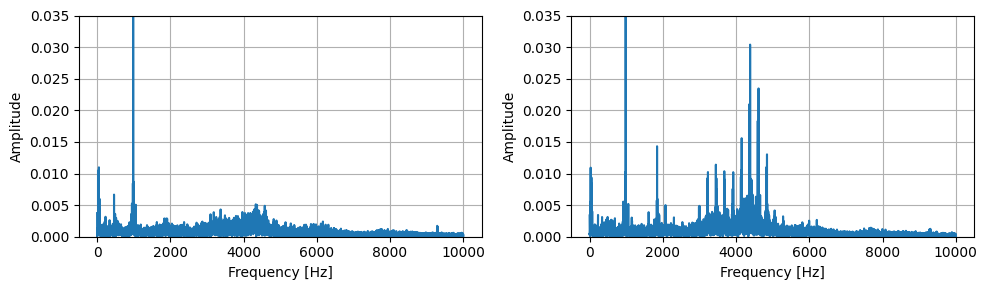

In [38]:
figure, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))

N = 20480
T = 1 / 20000    # 20 kHz

draw_frequency_amplitudes(
    pd.read_table(data_paths[1], sep="\t", header=None),
    axes[0],
    N=20480,
    T=T,
    column_index=0,
)
draw_frequency_amplitudes(
    pd.read_table(data_paths[30], sep="\t", header=None),
    axes[1],
    N=20480,
    T=T,
    column_index=0,
)
figure.tight_layout()

In [7]:
df = pd.DataFrame()
for file in data_paths:
    data = pd.read_table(file, sep="\t", header=None)[0]
    data = data.pipe(lambda d:2.0 / N * np.abs(fft(d)[0:N//2]))
    df = pd.concat([df, pd.DataFrame(data)],ignore_index=True)
print(len(df)/N)
data = (
    pd.DataFrame(df)
    .assign(timestamp=timestamps_repeated)
    .set_index("timestamp")
) # add up another column of date-time

20.0


import multiprocessing
def read_data():
    N = 20480
    data = pd.read_table(file, sep="\t", header=None)[0]
    data = data.pipe(lambda d:2.0 / N * np.abs(fft(d)[0:N//2]))
    return data
with multiprocessing.get_context('spawn').Pool(processes=os.cpu_count()) as pool:
    data_list = list(pool.map(read_data,data_paths,chunksize=10)) # Iterable #applying read_data function to each item in an iterable, distributing the work across a pool of worker processes
data = (pd.DataFrame(data_list)
    .assign(timestamp=timestamps)
    .set_index("timestamp")
) 

def read_data(data_path) -> list:
    N = 20480

    data = (
        pd.read_table(data_path, sep="\t", header=None) # The columns are separated by tabs, no header exists
        .pipe(lambda d:
            2.0 / N * np.abs(fft(d)[0:N//2])
        ) # The "pipe" function pass entire dataframe through a function in a clean, chainable way
        # In this case, all the data inside are passed through the fft
        # The reason that caused bottle neck
        # Suppose to take 1 data column instead of all 4 columns
        .flatten() 
    )
    return data

with Pool(processes=4) as pool:
    data_list = pool.map( #applying read_data function to each item in an iterable, distributing the work across a pool of worker processes
        read_data, 
        data_paths, # Iterable 
        chunksize=10
    )

data = (
    pd.DataFrame(data_list)
    .assign(timestamp=timestamps)
    .set_index("timestamp")
) # add up another column of date-time

In [8]:
print(len(timestamps))
print(timestamps[0])
print(timestamps[30])
print(timestamps[31])

40
2004-02-14 05:52:39
2004-02-17 05:32:39
2004-02-17 05:42:39


In [9]:
data_train = data.loc['2004-02-14 05:52:39':'2004-02-17 05:32:39'].to_numpy().astype("float32") # Claim data at this period of time stamp as training set
data_test = data.loc['2004-02-17 05:42:39':].to_numpy().astype("float32") # The rest are test data

val_size = int(0.2 * len(data_train))
train_size = len(data_train) - val_size

train_set, val_set = torch.utils.data.random_split(data_train, [train_size, val_size])

loader_config = dict(
    batch_size=16, 
    shuffle=True, 
    drop_last=True, 
    pin_memory=True, 
    num_workers=4,
)

train_loader = torch.utils.data.DataLoader(train_set, **loader_config)
val_loader = torch.utils.data.DataLoader(val_set, **loader_config)
test_loader = torch.utils.data.DataLoader(data_test, **loader_config)

In [10]:
print(len(train_loader))
print(len(val_loader))

15872
3968


In [11]:
class Encoder(nn.Module):
    def __init__(
        self, 
        number_of_columns: int, # assign the type of data
        latent_dimension: int, 
        activation_function: object = nn.GELU, # assign the activation function
    ):
        super().__init__()
        
        self.net = nn.Sequential(
            nn.Linear(number_of_columns, 256),
            nn.BatchNorm1d(256),
            activation_function(),
            
            nn.Linear(256, 64),
            nn.BatchNorm1d(64),
            activation_function(),
            
            nn.Linear(64, latent_dimension),
            nn.BatchNorm1d(latent_dimension),
            activation_function(),
        )

    def forward(self, x):
        return self.net(x)

In [12]:
class Decoder(nn.Module):
    def __init__(
        self, 
        number_of_columns: int,
        latent_dimension: int, 
        activation_function: object = nn.GELU,
    ):
        super().__init__()
        
        self.net = nn.Sequential(
            nn.Linear(latent_dimension, 64),
            nn.BatchNorm1d(64),
            activation_function(),
            
            nn.Linear(64, 256),
            nn.BatchNorm1d(256),
            activation_function(),

            nn.Linear(256, number_of_columns),
        )

    def forward(self, x):
        return self.net(x)

In [13]:
class Reconstructor(L.LightningModule):
    def __init__(
        self,
        number_of_columns: int,
        latent_dimension: int,
        encoder_class: object = Encoder, # assigning encoder class to the parameter in this class
        decoder_class: object = Decoder,
    ):
        super().__init__()
        
        # Saving hyperparameters of autoencoder
        self.save_hyperparameters()
        
        # Creating encoder and decoder
        self.encoder = encoder_class(number_of_columns, latent_dimension)
        self.decoder = decoder_class(number_of_columns, latent_dimension)
        
        self.number_of_columns = number_of_columns
        self.latent_dimension = latent_dimension

    def forward(self, x):
        """The forward function takes in an array and returns the reconstructed array."""
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

    def _get_reconstruction_loss(self, batch):
        """Given a batch of arrays, this function returns the reconstruction loss (MSE in our case)"""
        x = batch  # We do not need the labels        
        x_hat = self.forward(x)
        
        loss = F.mse_loss(x, x_hat, reduction="none")
        loss = loss.sum(dim=[1]).mean(dim=[0])
        
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        
        # Using a scheduler is optional but can be helpful.
        # The scheduler reduces the LR if the validation performance hasn't improved for the last N epochs
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.2, patience=20, min_lr=5e-5)
        
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}

    def training_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log("val_loss", loss, prog_bar=True)

    def test_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log("test_loss", loss)
    
    @torch.no_grad()
    def predict(
        self, 
        x,
    ):
        if x.shape[0] == 1:
            x = np.vstack([x, x])
        
        x = torch.from_numpy(x)
        x_hat = self.forward(x)
        
        loss = F.mse_loss(x, x_hat, reduction="none").mean(dim=1)
        
        return loss

In [14]:
# Train model
CHECKPOINT_PATH = Path("D:\\4. Seminar\\F. Grease_Bearing RUL detection\\1. Bearing diagnosis (Grease fault and others)\\SpindleVibration\\bearing-dataset") / "checkpoints" 

model_version = 1

callbacks = [
    # https://lightning.ai/docs/pytorch/stable/api/lightning.pytorch.callbacks.ModelCheckpoint.html
    ModelCheckpoint(),
    LearningRateMonitor("epoch"),
    RichModelSummary(),
    RichProgressBar(),
]

# Create a PyTorch Lightning trainer with the generation callback
trainer = L.Trainer(
    default_root_dir=CHECKPOINT_PATH / f"{model_version:03d}",
    accelerator="gpu",
    devices="auto",
    strategy="auto",
    max_epochs=100,
    callbacks=callbacks,
)

model = Reconstructor(
    number_of_columns=len(data.columns), 
    latent_dimension=16,
)
trainer.fit(model, train_loader, val_loader)

Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type    ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ encoder │ Encoder │ 18.7 K │ train │
│ 1 │ decoder │ Decoder │ 18.6 K │ train │
└───┴─────────┴─────────┴────────┴───────┘

Trainable params: 37.3 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 37.3 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 20                                                                                          
Modules in eval mode: 0

`Trainer.fit` stopped: `max_epochs=100` reached.


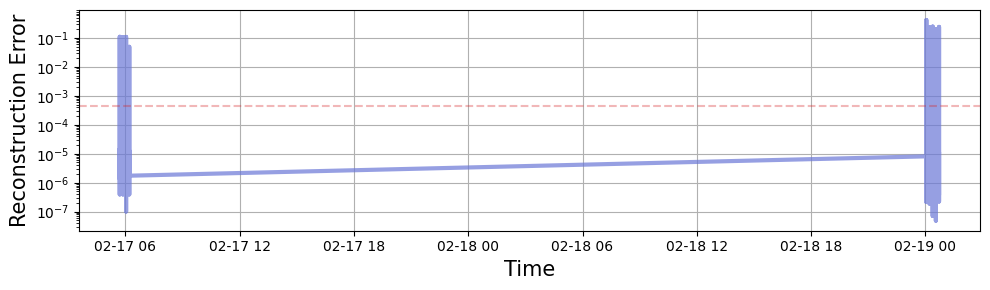

In [15]:
model.to("cpu")
loss_train = model.predict(data_train)
threshold = np.percentile(
    loss_train, # Set the 99th percentile of the training data as 
    q=99.9,
)
loss_predictions = model.predict(data_test)

figure, axis = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))

axis.plot(
    data.loc['2004-02-17 05:42:39':].index, #train loc'2004-02-12 10:32:39':'2004-02-15 08:42:39' test loc: 2004-02-15 08:52:39
    loss_predictions, 
    color="#6A77D7", 
    alpha=0.7, 
    linewidth=3,
)
axis.axhline(y=threshold, linestyle="--", color="tab:red", alpha=0.33)
axis.set_yscale("log")
axis.set_xlabel("Time", fontsize=15)
axis.set_ylabel("Reconstruction Error", fontsize=15)
axis.grid()

figure.tight_layout()

In [21]:
device =torch.device("cuda:0" if torch.cuda.is_available() else "Cpu")
model.to(device)
model.eval()
x_test_tensor = torch.tensor(data_test, dtype=torch.float32).to(device)
with torch.no_grad():
    x_test_pred = model(x_test_tensor)


x_test_pred_np = x_test_pred.cpu().numpy()
x_test_np = x_test_tensor.cpu().numpy()


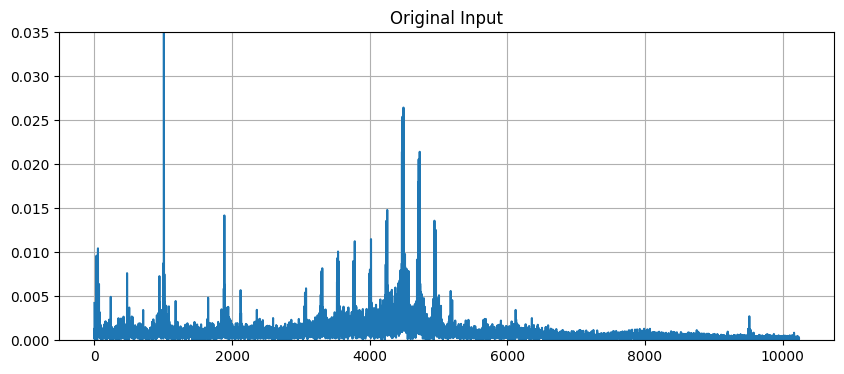

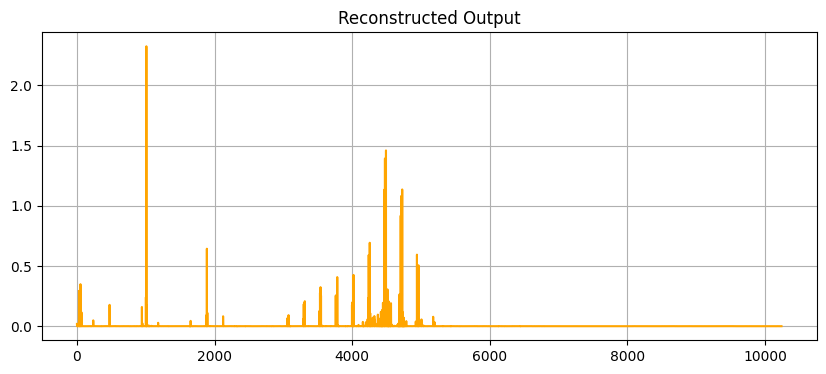

In [22]:
plt.figure(figsize=(10, 4))
plt.plot(x_test_np[0:N//2], label="Original")
plt.title("Original Input")
plt.grid(True)
plt.ylim(0, 0.035)
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(x_test_pred_np[0:N//2], label="Reconstruction", color='orange')
plt.title("Reconstructed Output")
plt.grid(True)
#plt.ylim(0, 0.035)
plt.show()

In [36]:
print(torch.mean(loss_predictions))
print(torch.mean(loss_train))
print(threshold)

tensor(9.9273e-05)
tensor(0.0001)
0.00043402307


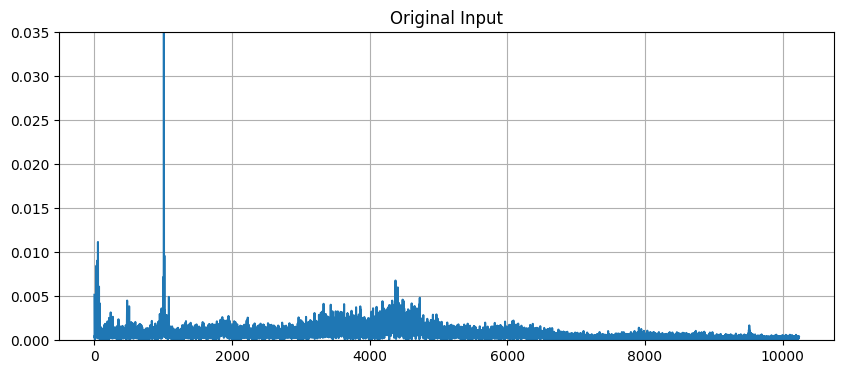

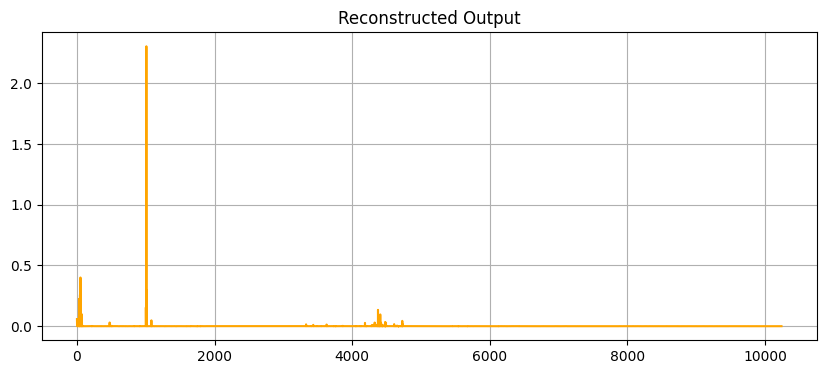

In [30]:
x_train_tensor = torch.tensor(data_train, dtype=torch.float32).to(device)
with torch.no_grad():
    x_train_pred = model(x_train_tensor)


x_train_pred_np = x_train_pred.cpu().numpy()
x_train_np = x_train_tensor.cpu().numpy()
plt.figure(figsize=(10, 4))
plt.plot(x_train_np[5*N//2:6*N//2], label="Original")
plt.title("Original Input")
plt.grid(True)
plt.ylim(0, 0.035)
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(x_train_pred_np[5*N//2:6*N//2], label="Reconstruction", color='orange')
plt.title("Reconstructed Output")
plt.grid(True)
#plt.ylim(0, 0.035)
plt.show()